# Import & Utils

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import set_config; set_config(display='diagram')

In [3]:
import datetime
from scipy import stats
from pathlib import Path
class Logger:
    def __init__(self):
        self.log = []

    def add_grid(self,grid,n_best=2):
        df = pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_score")
        now = datetime.datetime.now()
        for i in range(min(df.shape[0],n_best)):
            dd = df.iloc[-i-1,:].params
            dd.update({"mean_test_score":df.iloc[-i-1,:].mean_test_score,
                       "date":now})
            self.log.append(dd)

    def df(self):
        return pd.DataFrame(self.log).sort_values(by="mean_test_score",ascending=False)

    def to_csv(self, file, exists="error"):
        assert exists in ["error","erase","append"]
        assert Path(file).suffix == ".csv",f"{file} doit avoir l'extension '.csv'"
        if Path(file).exists():
            if exists=="error":
                raise FileExistsError(f"{file} existe déjà")
            elif exists=="erase":
                pass
            elif exists=="append":
                other = self.__class__.from_csv(file)
                other.log += self.log
                return other.to_csv(file, exists="erase")
            else:
                raise ValueError(f"{exists} non reconnu, 'error','erase','append' attendus")
        self.df().to_csv(file,index=False)

    @classmethod
    def from_csv(cls, file):
        if not Path(file).exists():
            raise FileExistsError(f"{file} n'existe pas")
        result = cls()
        result.log = pd.read_csv(file,index_col=None).to_dict("records")
        return result

In [4]:
ROOT_PATH = Path.cwd().parent
DATA_PATH = ROOT_PATH / "raw_data"

# Raw Data
- date: date d'enregistrement
- numer_sta: numéro unique de la station
- Latitude: Latitude
- Longitude: Longitude
- Altitude: Altitude
- pmer: pression au niveau de la mer (hpa)
- dd: direction du vent a 10m (rose de 360)
- ff: force du vent a 10m (m/s)
- t: tempe sous abri inst. (degre C)
- u: humidité
- rr3: hauteur de precipitations en 3 heure (mm et 1/10)
- pres: pression à l'altitude de la station  (hpa)
- dd_sin: composante sin de direction du vent 
- dd_cos: composante cos de direction du vent 

## Numeric info

In [5]:
df = pd.read_csv(DATA_PATH/"data_weather.csv")
df

,date,numer_sta,Latitude,Longitude,Altitude,pmer,dd,ff,t,u,ssfrai,rr3,pres,dd_sin,dd_cos
0,2010-01-01 00:00:00,7510.0,44.830667,-0.691333,47.0,99050.0,230.0,9.8,9.6,81.0,0.0,0,98410.0,-0.766044,-6.427876e-01
1,2010-01-01 03:00:00,7510.0,44.830667,-0.691333,47.0,99160.0,250.0,11.8,8.7,87.0,0.0,0,98520.0,-0.939693,-3.420201e-01
2,2010-01-01 06:00:00,7510.0,44.830667,-0.691333,47.0,99570.0,290.0,5.1,7.6,91.0,0.0,0,98920.0,-0.939693,3.420201e-01
3,2010-01-01 09:00:00,7510.0,44.830667,-0.691333,47.0,99990.0,310.0,5.7,6.8,92.0,0.0,0,99340.0,-0.766044,6.427876e-01
4,2010-01-01 12:00:00,7510.0,44.830667,-0.691333,47.0,100350.0,310.0,6.2,6.6,82.0,0.0,0,99690.0,-0.766044,6.427876e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505852,2021-07-31 09:00:00,7650.0,43.437667,5.216000,9.0,100920.0,310.0,3.2,27.2,58.0,0.0,0,100560.0,-0.766044,6.427876e-01
505853,2021-07-31 12:00:00,7650.0,43.437667,5.216000,9.0,100770.0,270.0,6.1,30.6,49.0,0.0,0,100410.0,-1.000000,-1.836970e-16
505854,2021-07-31 15:00:00,7650.0,43.437667,5.216000,9.0,100680.0,310.0,8.2,30.0,40.0,0.0,0,100320.0,-0.766044,6.427876e-01
505855,2021-07-31 18:00:00,7650.0,43.437667,5.216000,9.0,100750.0,320.0,8.0,27.9,45.0,0.0,0,100390.0,-0.642788,7.660444e-01


In [6]:
df.describe()

,numer_sta,Latitude,Longitude,Altitude,pmer,dd,ff,t,u,ssfrai,rr3,pres,dd_sin,dd_cos
count,505857.000000,505857.000000,505857.000000,505857.000000,5.058570e+05,505857.000000,505857.000000,505857.000000,505857.000000,505857.000000,505857.000000,505791.000000,5.058570e+05,505857.000000
mean,7464.116831,45.478172,3.451461,193.196708,inf,185.492402,3.417473,13.266307,71.291632,0.000035,0.018035,99359.894818,-7.266871e-02,0.096686
std,161.478737,1.502581,2.724426,217.479032,NaN,112.882202,2.350552,7.781763,18.898504,0.003194,0.133077,2597.553814,6.482709e-01,0.751743
min,7222.000000,43.437667,-1.608833,2.000000,1.059852e-205,0.000000,0.000000,-19.700000,1.000000,0.000000,0.000000,88160.000000,-1.000000e+00,-1.000000
25%,7280.000000,43.648833,1.175000,26.000000,1.012600e+05,80.000000,1.600000,7.700000,58.000000,0.000000,0.000000,98430.000000,-6.427876e-01,-0.642788
50%,7481.000000,45.726500,3.963167,151.000000,1.017500e+05,190.000000,3.000000,13.000000,74.000000,0.000000,0.000000,99960.000000,-2.449294e-16,0.173648
75%,7630.000000,47.150000,5.216000,263.000000,1.022900e+05,280.000000,4.600000,18.700000,87.000000,0.000000,0.000000,101120.000000,5.000000e-01,0.866025
max,7690.000000,47.614333,7.510000,871.000000,inf,360.000000,23.500000,42.000000,100.000000,0.990000,1.000000,104170.000000,1.000000e+00,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505857 entries, 0 to 505856
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       505857 non-null  object 
 1   numer_sta  505857 non-null  float64
 2   Latitude   505857 non-null  float64
 3   Longitude  505857 non-null  float64
 4   Altitude   505857 non-null  float64
 5   pmer       505857 non-null  float64
 6   dd         505857 non-null  float64
 7   ff         505857 non-null  float64
 8   t          505857 non-null  float64
 9   u          505857 non-null  float64
 10  ssfrai     505857 non-null  float64
 11  rr3        505857 non-null  int64  
 12  pres       505791 non-null  float64
 13  dd_sin     505857 non-null  float64
 14  dd_cos     505857 non-null  float64
dtypes: float64(13), int64(1), object(1)
memory usage: 57.9+ MB


In [8]:
df.isna().sum(axis=0)/df.shape[0]

date         0.00000
numer_sta    0.00000
Latitude     0.00000
Longitude    0.00000
Altitude     0.00000
pmer         0.00000
dd           0.00000
ff           0.00000
t            0.00000
u            0.00000
ssfrai       0.00000
rr3          0.00000
pres         0.00013
dd_sin       0.00000
dd_cos       0.00000
dtype: float64

## Viz

In [6]:
data = df.drop(columns=["date","pmer"])
n = data.shape[1]
r = 6
c = n // r + 1 * min(1,n%r)

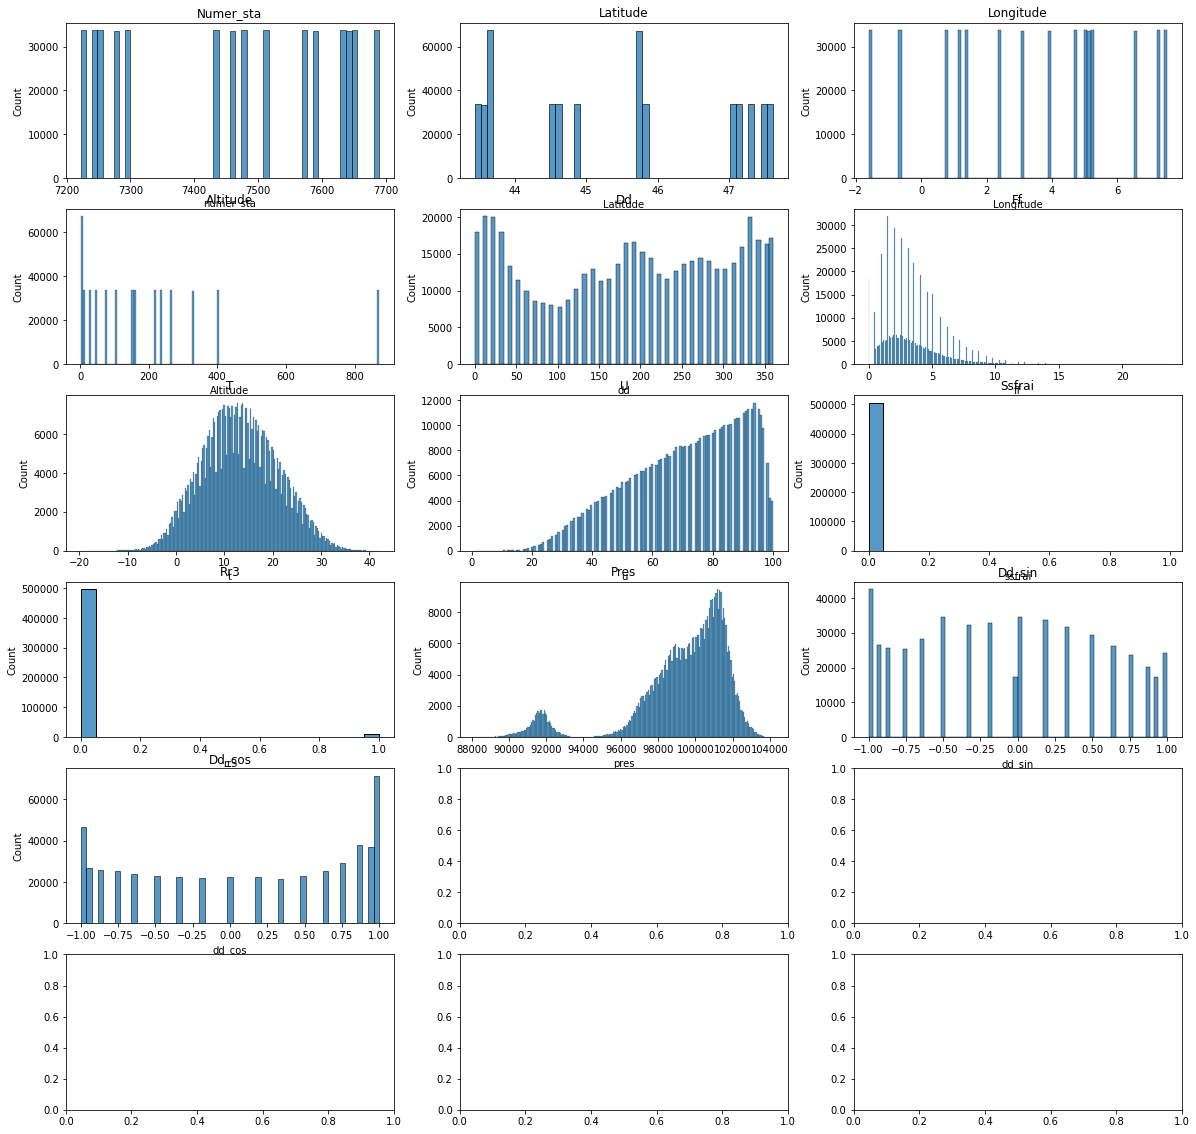

In [10]:
fig,axes = plt.subplots(r,c,figsize=(20,20))
i = -1
for col in data.columns:
    i+= 1
    ax = fig.axes[i]
    sns.histplot(data[col],ax=ax)
    ax.set(title=col.capitalize())

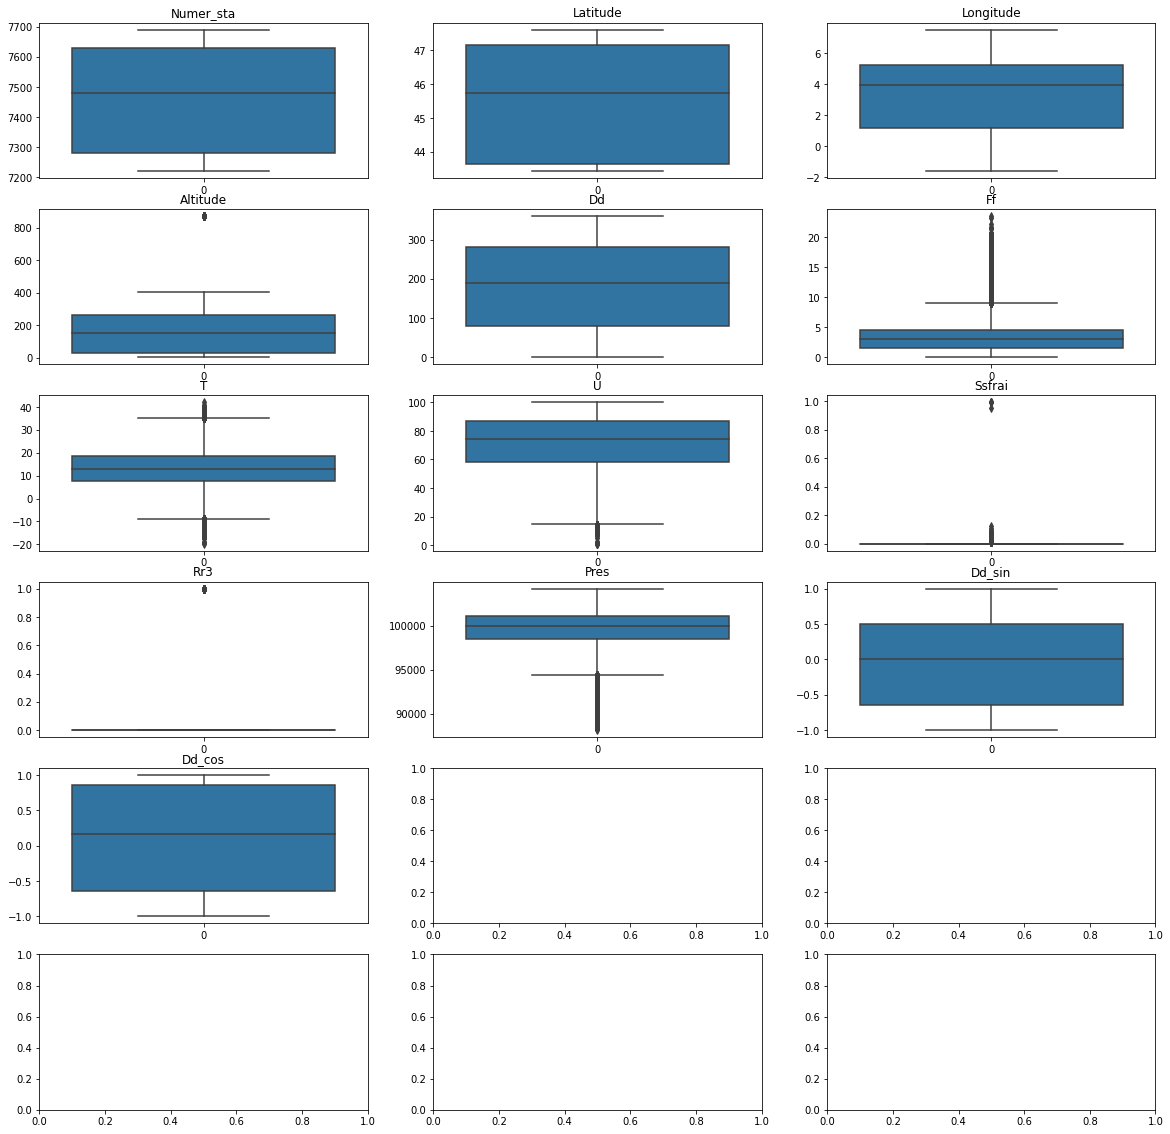

In [11]:
fig,axes = plt.subplots(r,c,figsize=(20,20))
i = -1
for col in data.columns:
    i+= 1
    ax = fig.axes[i]
    sns.boxplot(data=data[col],ax=ax)
    ax.set(title=col.capitalize())

### Date case

<AxesSubplot:xlabel='date'>

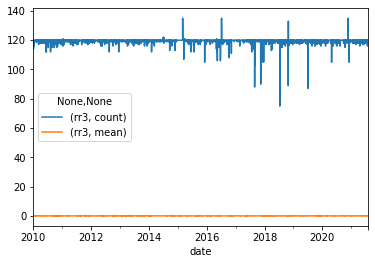

In [12]:
df[["rr3"]].assign(date = pd.to_datetime(df.date)).set_index("date").resample("D").aggregate(["count","mean"]).plot()

### Pmer case

In [13]:
pmerlog = np.log(df.pmer)

In [14]:
(pmerlog==np.inf).sum()/pmerlog.shape[0]

0.0002569896235497384

In [15]:
((df.pmer>=200000)|(df.pmer<=50000)).sum()/df.pmer.shape[0]

0.06656228934264032

### Ssfrai case

In [16]:
df.ssfrai.value_counts()

0.00    505002
0.01       654
0.02        95
0.03        34
0.04        31
0.05        17
0.06         7
0.08         6
0.99         4
0.07         3
0.10         2
0.12         1
0.95         1
Name: ssfrai, dtype: int64

<AxesSubplot:ylabel='Frequency'>

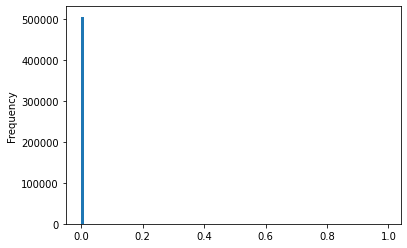

In [17]:
df.ssfrai.plot.hist(bins=100)

## Conclusion
- Pression plutôt en Pa que hPa
- Données non balancées.
- 10 années d'observation
- Numer sta devrait est catégorical. Trop de valeur => Drop colonne
- Données manquantes
    - Pressure peu de valeurs manquantes => Drop les lignes
    - pmer
        - 7% des données non réalistes => Drop colonne
- Date à caster sur les bonnes features
- Ssfrai non documenté et grosse dispersion => Drop colonne

# Target Creation
L'objectif est de prédire si un évènement pluvieux a lieu en fonction d'autres grandeurs présentes dans le dataset.


On considère un événement pluvieux à partir du moment ou rr3 > 0 (Evidemment, la colonne rr3 ne pourra donc pas faire partie des features puisque que la target en découle directement).

In [7]:
from sklearn.model_selection import train_test_split
data = df.drop_duplicates().drop(columns=["pmer","ssfrai","numer_sta"])
data = data.dropna()
y = (data.rr3>0).astype(int)
X = data.drop(columns=["rr3"])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

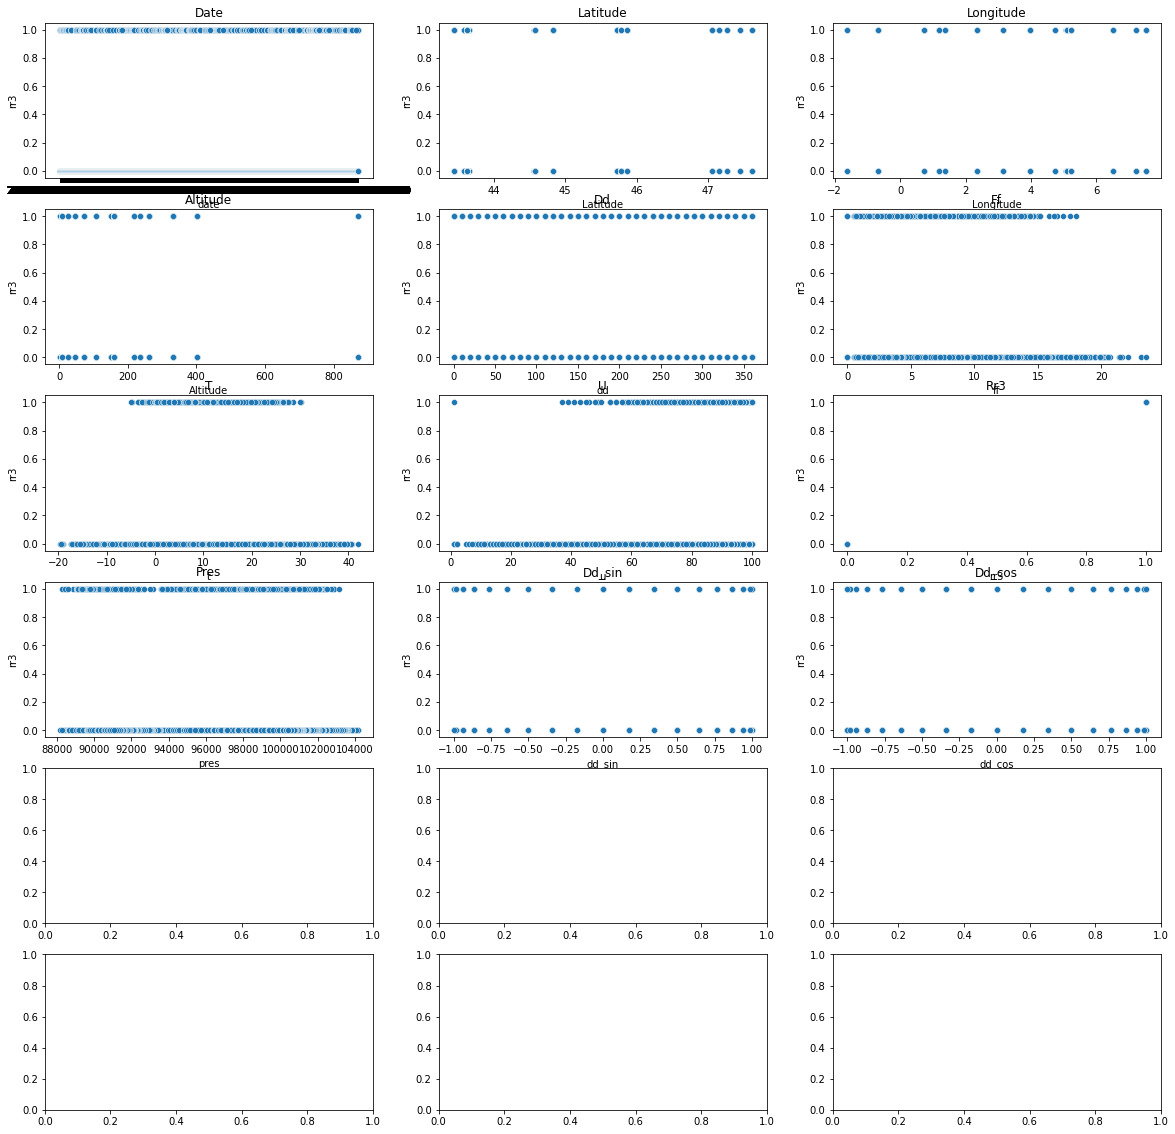

In [19]:
fig,axes = plt.subplots(r,c,figsize=(20,20))
i = -1
for col in data.columns:
    i+= 1
    ax = fig.axes[i]
    sns.scatterplot(x=data[col],y=y,ax=ax)
    ax.set(title=col.capitalize())

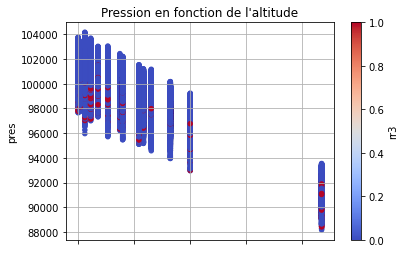

In [32]:
ax = df.plot.scatter("Altitude","pres",c="rr3",cmap="coolwarm")
ax.set(title="Pression en fonction de l'altitude")
plt.grid()

# Baseline

In [8]:
from sklearn.metrics import accuracy_score,precision_score,classification_report
most_frequent = y_train.mode().iloc[0]
y_pred_baseline = pd.Series(most_frequent,y_train.index)
print(classification_report(y_train,y_pred_baseline))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    347673
           1       0.00      0.00      0.00      6334

    accuracy                           0.98    354007
   macro avg       0.49      0.50      0.50    354007
weighted avg       0.96      0.98      0.97    354007



/home/maxime/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/maxime/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/maxime/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

# Pipe
## Preproc

In [9]:
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,OneHotEncoder

In [10]:
class DateTransformer(TransformerMixin, BaseEstimator):
    # BaseEstimator generates get_params() and set_params() methods that all pipelines require
    # TransformerMixin creates fit_transform() method from fit() and transform()

    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Store here what needs to be stored during .fit(X_train) as instance attributes.
        # Return "self" to allow chaining .fit().transform()
        return self

    def transform(self, X, y=None):
        # Return result as dataframe for integration into ColumnTransformer
        s = pd.to_datetime(X.date)
        y = s.dt.year
        m = s.dt.month
        mc = np.cos(2*np.pi*m/12)
        ms = np.sin(2*np.pi*m/12)
        cols = self.get_feature_names_out()
        return pd.DataFrame({"year":y,"monthc":mc,"months":ms,"month":m})
        

    def get_feature_names_out(self,*args):
        return ["year","monthc","months","month"]

In [11]:
date_tr = Pipeline([
    ("date_tr",DateTransformer()),
    ("scaler_tr",ColumnTransformer([
        ("mnmxscaler",MinMaxScaler(),["months","monthc","year"]),
        
    ],remainder="drop"))
])
date_tr

Pipeline(steps=[('date_tr', DateTransformer()),
                ('scaler_tr',
                 ColumnTransformer(transformers=[('mnmxscaler', MinMaxScaler(),
                                                  ['months', 'monthc',
                                                   'year'])]))])

In [12]:
pipe_pr = ColumnTransformer([
    ("date_tr",date_tr,["date"]),
    ("stdscaler_tr",StandardScaler(),["Altitude","ff","t","pres"]),
    ("mxmxscaler_tr",MinMaxScaler(),["Latitude","Longitude","u","dd_sin","dd_cos"]),    
],remainder="drop")
pipe_pr

ColumnTransformer(transformers=[('date_tr',
                                 Pipeline(steps=[('date_tr', DateTransformer()),
                                                 ('scaler_tr',
                                                  ColumnTransformer(transformers=[('mnmxscaler',
                                                                                   MinMaxScaler(),
                                                                                   ['months',
                                                                                    'monthc',
                                                                                    'year'])]))]),
                                 ['date']),
                                ('stdscaler_tr', StandardScaler(),
                                 ['Altitude', 'ff', 't', 'pres']),
                                ('mxmxscaler_tr', MinMaxScaler(),
                                 ['Latitude', 'Longitude', 'u', 'dd_sin',
                                  'dd_cos'])])

## Simplest model

In [13]:
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import cross_validate

In [29]:
pipe_simple = Pipeline([
    ("preproc",pipe_pr),
    ("model",LogisticRegression(max_iter=1000))
])

In [30]:
cv_results = cross_validate(pipe_simple, X_train, y_train, cv=5,
                            scoring=['accuracy',
                                     'precision'])
display(pd.DataFrame(cv_results))
pd.DataFrame(cv_results).mean()

,fit_time,score_time,test_accuracy,test_precision
0,5.638976,0.189908,0.981710,0.400000
1,5.236711,0.184550,0.981554,0.344828
2,4.166907,0.161350,0.981822,0.444444
3,4.559333,0.182577,0.981836,0.457447
4,5.987606,0.188728,0.981540,0.325000


fit_time          5.117906
score_time        0.181423
test_accuracy     0.981692
test_precision    0.394344
dtype: float64

### Conclusion
Nette amélioration de la précision. Elle reste toutefois faible.

## Resampling

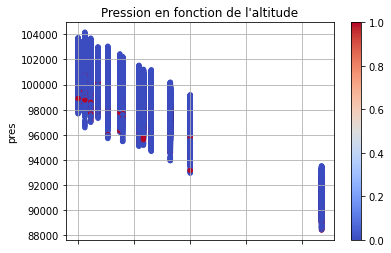

In [15]:
def plot_press_alt(X_train,y_train):
    ax = X_train.plot.scatter("Altitude","pres",c=y_train,cmap="coolwarm")
    ax.set(title="Pression en fonction de l'altitude")
    plt.grid()
plot_press_alt(X_train,y_train)

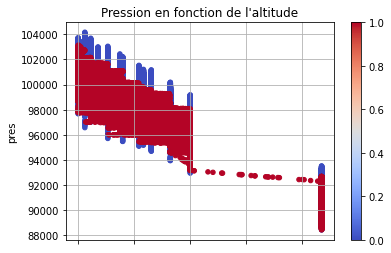

In [16]:
from imblearn.over_sampling import SMOTE
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
oversample = SMOTE()
X_train_prep =X_train.assign(date = pd.DatetimeIndex(X_train.date).to_julian_date())
X_train_rebal, y_train_rebal = oversample.fit_resample(X_train_prep, y_train)
X_train_rebal = X_train_rebal.assign(date=pd.to_datetime(X_train_rebal.date, unit = 'D', origin = 'julian'))
plot_press_alt(X_train_rebal,y_train_rebal)


In [35]:
pipe_simple.set_params(model__max_iter=1000)
cv_results = cross_validate(pipe_simple, X_train_rebal,y_train_rebal, cv=5,
                            scoring=['accuracy',
                                     'precision'])
display(pd.DataFrame(cv_results))
pd.DataFrame(cv_results).mean()

,fit_time,score_time,test_accuracy,test_precision
0,4.282652,0.165673,0.876480,0.850041
1,3.665951,0.153358,0.876465,0.847694
2,4.239594,0.158885,0.876451,0.848960
3,4.466542,0.156245,0.877752,0.849927
4,4.380400,0.166925,0.878773,0.850417


fit_time          4.207028
score_time        0.160217
test_accuracy     0.877184
test_precision    0.849408
dtype: float64

### Conclusion
Nette amélioration de la précision, au détriment de l'accuracy.

## Feature Engineering
### Importance

In [36]:
from sklearn.inspection import permutation_importance
pipe_simple.fit(X_train_rebal, y_train_rebal)
permutation_score = permutation_importance(pipe_simple, X_train_rebal, y_train_rebal, n_repeats=10)

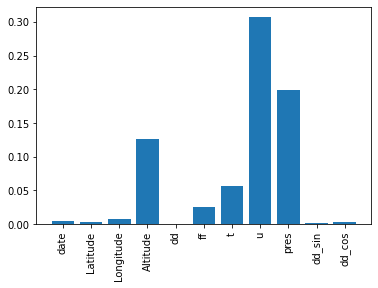

In [37]:
plt.bar(height=permutation_score.importances_mean,x=X_train_rebal.columns)
plt.xticks(rotation=90);

In [38]:
permutation_score.importances_std

array([7.26500028e-05, 9.72640729e-05, 1.73479006e-04, 3.40266173e-04,
       0.00000000e+00, 2.53523656e-04, 2.01578986e-04, 6.73311795e-04,
       4.45659746e-04, 1.12665330e-04, 1.73050568e-04])

In [18]:
pipe_pr_modif_imp = ColumnTransformer([
    ("stdscaler_tr",StandardScaler(),["Altitude","ff","t","pres"]),
    ("mxmxscaler_tr",MinMaxScaler(),["u"]),    
],remainder="drop")
pipe_pr_modif_imp

ColumnTransformer(transformers=[('stdscaler_tr', StandardScaler(),
                                 ['Altitude', 'ff', 't', 'pres']),
                                ('mxmxscaler_tr', MinMaxScaler(), ['u'])])

In [19]:
pipe_simple_imp = Pipeline([
    ("preproc",pipe_pr_modif_imp),
    ("model",LogisticRegression())
])

In [41]:
cv_results = cross_validate(pipe_simple_imp, X_train_rebal,y_train_rebal, cv=5,
                            scoring=['accuracy',
                                     'precision'])
display(pd.DataFrame(cv_results))
pd.DataFrame(cv_results).mean()

,fit_time,score_time,test_accuracy,test_precision
0,0.737221,0.059099,0.865577,0.841035
1,0.775957,0.061013,0.866310,0.839569
2,0.867338,0.071236,0.866253,0.840615
3,0.978103,0.058725,0.866755,0.840389
4,0.891924,0.084520,0.868273,0.841932


fit_time          0.850109
score_time        0.066918
test_accuracy     0.866634
test_precision    0.840708
dtype: float64

### Delta pression theo
Pour la beauté du sens physique,
non utilisé ou seul utilisé car créerait de la multicolinéarité

In [20]:
class DeltaPressTransformer(TransformerMixin, BaseEstimator):
    # BaseEstimator generates get_params() and set_params() methods that all pipelines require
    # TransformerMixin creates fit_transform() method from fit() and transform()

    def __init__(self):
        self.regression = LinearRegression()

    def fit(self, X, y=None):
        # Store here what needs to be stored during .fit(X_train) as instance attributes.
        # Return "self" to allow chaining .fit().transform()
        self.regression.fit(X[["Altitude"]],X["pres"])
        return self

    def transform(self, X, y=None):
        # Return result as dataframe for integration into ColumnTransformer
        pres_th = self.regression.predict(X[["Altitude"]])
        return pd.DataFrame(X["pres"].values - pres_th,columns=self.get_feature_names_out())
        

    def get_feature_names_out(self,*args):
        return ["delta_pres"]

In [21]:
transf = DeltaPressTransformer()
delta = transf.fit_transform(X_train_rebal,y_train_rebal)

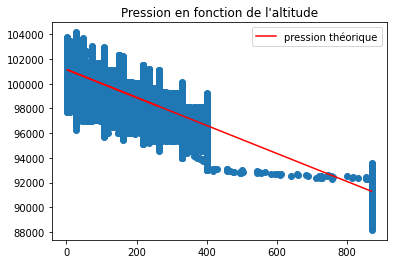

In [44]:
plt.scatter(X_train_rebal.Altitude,X_train_rebal.pres)
plt.plot(X_train_rebal.Altitude,transf.regression.predict(X_train_rebal[["Altitude"]]),color="red",label="pression théorique")
plt.gca().set(title="Pression en fonction de l'altitude")
plt.legend();

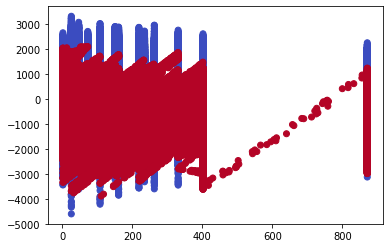

In [45]:
plt.scatter(X_train_rebal.Altitude,delta,c=y_train_rebal,cmap="coolwarm")

In [22]:
pipe_pr_modif = ColumnTransformer([
    ("date_tr",date_tr,["date"]),
    ("stdscaler_tr",StandardScaler(),["Altitude","ff","t"]),
    ("mxmxscaler_tr",MinMaxScaler(),["Latitude","Longitude","u","dd_sin","dd_cos"]),    
],remainder="drop")
pipe_pr_modif

ColumnTransformer(transformers=[('date_tr',
                                 Pipeline(steps=[('date_tr', DateTransformer()),
                                                 ('scaler_tr',
                                                  ColumnTransformer(transformers=[('mnmxscaler',
                                                                                   MinMaxScaler(),
                                                                                   ['months',
                                                                                    'monthc',
                                                                                    'year'])]))]),
                                 ['date']),
                                ('stdscaler_tr', StandardScaler(),
                                 ['Altitude', 'ff', 't']),
                                ('mxmxscaler_tr', MinMaxScaler(),
                                 ['Latitude', 'Longitude', 'u', 'dd_sin',
                                  'dd_cos'])])

In [23]:
pipe_pr2 = FeatureUnion([
    ("delta_pres",DeltaPressTransformer()),
    ("pipe_pr",pipe_pr_modif)])
pipe_pr2

FeatureUnion(transformer_list=[('delta_pres', DeltaPressTransformer()),
                               ('pipe_pr',
                                ColumnTransformer(transformers=[('date_tr',
                                                                 Pipeline(steps=[('date_tr',
                                                                                  DateTransformer()),
                                                                                 ('scaler_tr',
                                                                                  ColumnTransformer(transformers=[('mnmxscaler',
                                                                                                                   MinMaxScaler(),
                                                                                                                   ['months',
                                                                                                                    'monthc',
                                                                                                                    'year'])]))]),
                                                                 ['date']),
                                                                ('stdscaler_tr',
                                                                 StandardScaler(),
                                                                 ['Altitude',
                                                                  'ff', 't']),
                                                                ('mxmxscaler_tr',
                                                                 MinMaxScaler(),
                                                                 ['Latitude',
                                                                  'Longitude',
                                                                  'u', 'dd_sin',
                                                                  'dd_cos'])]))])

In [24]:
pipe_simple2 = Pipeline([
    ("preproc",pipe_pr2),
    ("model",LogisticRegression(max_iter=1000))
])

In [ ]:
cv_results = cross_validate(pipe_simple2, X_train_rebal,y_train_rebal, cv=5,
                            scoring=['accuracy',
                                     'precision'])
display(pd.DataFrame(cv_results))
pd.DataFrame(cv_results).mean()

### Distance à la position moyenne

In [50]:
class DistanceMoyenneTransformer(TransformerMixin, BaseEstimator):
    # BaseEstimator generates get_params() and set_params() methods that all pipelines require
    # TransformerMixin creates fit_transform() method from fit() and transform()

    def __init__(self):
        pass
        
    def haversine_distance(self,data,lon_lon_lat_lat = [0,1,2,3]):
        assert data.shape[1]==4.
        datar = np.radians(data)        
        dlon = data.iloc[:,lon_lon_lat_lat[:2]].diff(axis=1).iloc[:,-1]
        dlat = data.iloc[:,lon_lon_lat_lat[2:]].diff(axis=1).iloc[:,-1]        
        a = np.sin(dlat / 2) ** 2 + np.cos(data.iloc[:,lon_lon_lat_lat[2]]) * np.cos(data.iloc[:,lon_lon_lat_lat[3]]) * np.sin(dlon / 2) ** 2
        return 2 * 6371 * np.arcsin(np.sqrt(a))

    def fit(self, X, y=None):
        # Store here what needs to be stored during .fit(X_train) as instance attributes.
        # Return "self" to allow chaining .fit().transform()
        return self

    def transform(self, X, y=None):
        # Return result as dataframe for integration into ColumnTransformer
        data = X[["Latitude","Longitude"]].assign(lat2=X.Latitude.mean(),long2=X.Longitude.mean())
        return pd.DataFrame(self.haversine_distance(data,[1,3,0,2]),columns=self.get_feature_names_out())
        

    def get_feature_names_out(self,*args):
        return ["haversine_distance"]

In [51]:
transfor  = DistanceMoyenneTransformer()
dist = transfor.fit_transform(X_train_rebal)

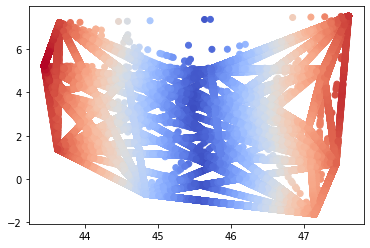

In [52]:
plt.scatter(X_train_rebal.Latitude,X_train_rebal.Longitude,c=dist.iloc[:,0],cmap="coolwarm")

In [53]:
pipe_pr3 = FeatureUnion([
    ("dist_tr",DistanceMoyenneTransformer()),
    ("pipe_pr",pipe_pr_modif_imp)])
pipe_pr3

FeatureUnion(transformer_list=[('dist_tr', DistanceMoyenneTransformer()),
                               ('pipe_pr',
                                ColumnTransformer(transformers=[('stdscaler_tr',
                                                                 StandardScaler(),
                                                                 ['Altitude',
                                                                  'ff', 't',
                                                                  'pres']),
                                                                ('mxmxscaler_tr',
                                                                 MinMaxScaler(),
                                                                 ['u'])]))])

In [54]:
pipe_simple3 = Pipeline([
    ("preproc",pipe_pr3),
    ("model",LogisticRegression(max_iter=1000))
])

In [55]:
cv_results = cross_validate(pipe_simple3, X_train_rebal,y_train_rebal, cv=5,
                            scoring=['accuracy',
                                     'precision'])
display(pd.DataFrame(cv_results))
pd.DataFrame(cv_results).mean()

,fit_time,score_time,test_accuracy,test_precision
0,9.583629,0.092025,0.868173,0.845259
1,1.849810,0.089781,0.673799,0.668306
2,5.100197,0.090557,0.814112,0.801888
3,12.565297,0.092634,0.869798,0.844532
4,9.166279,0.100475,0.870625,0.844635


fit_time          7.653042
score_time        0.093094
test_accuracy     0.819301
test_precision    0.800924
dtype: float64

### Conclusion

Le modèle 'physique' semble le plus performant avec une baseline precision à 0.845

## Fine Tuning

In [64]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [65]:
mylogger = Logger()

In [82]:
# Choix du modèle
params = {"model":[LogisticRegression(max_iter=1000),XGBClassifier(use_label_encoder=False),RandomForestClassifier()]}

grid = GridSearchCV(pipe_simple2,params,
                          n_jobs=-1,
                          scoring="precision",
                          cv=5,verbose=1
                          )
grid.fit(X_train_rebal,y_train_rebal)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[22:18:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        FeatureUnion(transformer_list=[('delta_pres',
                                                                        DeltaPressTransformer()),
                                                                       ('pipe_pr',
                                                                        ColumnTransformer(transformers=[('date_tr',
                                                                                                         Pipeline(steps=[('date_tr',
                                                                                                                          DateTransformer()),
                                                                                                                         ('scaler_tr',
                                                                                                                          ColumnTransformer(transformers=[('mnmxscaler',
                                                                                                                                                           MinMaxScaler(),
                                                                                                                                                           ['months',
                                                                                                                                                            'monthc',
                                                                                                                                                            'year']),
                                                                                                                                                          ('ohe',
                                                                                                                                                           OneHotEncoder(sp...
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=None,
                                                 reg_alpha=None,
                                                 reg_lambda=None,
                                                 scale_pos_weight=None,
                                                 subsample=None,
                                                 tree_method=None,
                                                 use_label_encoder=False,
                                                 validate_parameters=None,
                                                 verbosity=None),
                                   RandomForestClassifier()]},
             scoring='precision', verbose=1)

[22:10:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [80]:
mylogger.add_grid(grid,n_best=20)

mylogger.df()

,model,mean_test_score,date
0,"XGBClassifier(base_score=None, booster=None, c...",0.996761,2022-05-19 22:10:25.068445
3,"XGBClassifier(base_score=None, booster=None, c...",0.996761,2022-05-19 22:10:25.068445
6,"XGBClassifier(base_score=None, booster=None, c...",0.996761,2022-05-19 22:10:25.068445
1,RandomForestClassifier(),0.988316,2022-05-19 22:10:25.068445
4,RandomForestClassifier(),0.988316,2022-05-19 22:10:25.068445
7,RandomForestClassifier(),0.988316,2022-05-19 22:10:25.068445
2,LogisticRegression(),0.789956,2022-05-19 22:10:25.068445
5,LogisticRegression(),0.789956,2022-05-19 22:10:25.068445
8,LogisticRegression(),0.789956,2022-05-19 22:10:25.068445


In [83]:
mylogger.to_csv("my_logger.csv",exists="append")

In [84]:
cv_results = cross_validate(grid.best_estimator_, X_train_rebal,y_train_rebal, cv=5,
                            scoring=['accuracy',
                                     'precision'])
display(pd.DataFrame(cv_results))
pd.DataFrame(cv_results).mean()

[22:23:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:23:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:23:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:24:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,fit_time,score_time,test_accuracy,test_precision
0,23.610708,0.209347,0.954662,0.999542
1,26.311956,0.218074,0.997174,0.995755
2,21.890737,0.191414,0.997109,0.995797
3,23.739116,0.206661,0.997699,0.996314
4,22.420380,0.184227,0.997540,0.996398


fit_time          23.594579
score_time         0.201945
test_accuracy      0.988837
test_precision     0.996761
dtype: float64

In [85]:
y_pred_test = grid.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    148993
           1       0.46      0.12      0.19      2725

    accuracy                           0.98    151718
   macro avg       0.72      0.56      0.59    151718
weighted avg       0.97      0.98      0.98    151718



### Sauvegarde du meilleur model

In [71]:
import joblib
joblib.dump(grid.best_estimator_, 'model.joblib')

['model.joblib']